# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16839277356598323756
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4488262680109263735
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Fri Dec 17 20:47:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'Xception'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 2
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1"
T_all_labels = "T0", "T1"

#base_path = ''
base_path = 'gdrive/My Drive/Research_1_2_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_Xception_None S_Xception_imagenet T_Xception_None T_Xception_imagenet


['S_Xception_imagenet',
 'S_Xception_None',
 'T_Xception_imagenet',
 'T_Xception_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1440, 128, 128, 3) (1440, 1)
(480, 128, 128, 3) (480, 1)
(480, 128, 128, 3) (480, 1)

(1920, 128, 128, 3) (1920, 1)
(640, 128, 128, 3) (640, 1)
(640, 128, 128, 3) (640, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1440, 128, 128, 3) (1440, 2)
(480, 128, 128, 3) (480, 2)
(480, 128, 128, 3) (480, 2)

(1920, 128, 128, 3) (1920, 2)
(640, 128, 128, 3) (640, 2)
(640, 128, 128, 3) (640, 2)


## 2-2. Image Check

xTrain_S image Numbers :  1440
xTrain_S image Numbers // 10 :  144
10


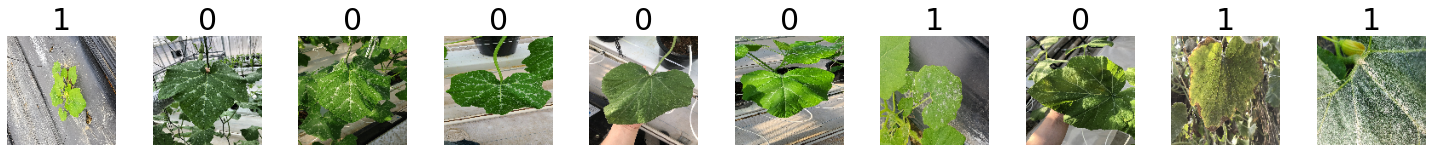

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  1920
xTrain_S image Numbers // 10 :  192
10


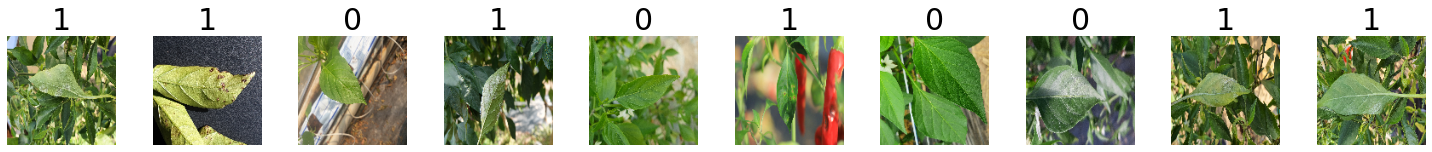

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.Xception (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.Xception (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 19s 309ms/step - loss: 0.3060 - accuracy: 0.8778 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
23/23 [==============================] - 6s 246ms/step - loss: 0.0677 - accuracy: 0.9771 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/100
23/23 [==============================] - 6s 248ms/step - loss: 0.0577 - accuracy: 0.9799 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 4/100
23/23 [==============================] - 6s 248ms/step - loss: 0.0716 - accuracy: 0.9757 - val_loss: 0.6968 - val_accuracy: 0.5000
Epoch 5/100
23/23 [==============================] - 6s 247ms/step - loss: 0.0334 - accuracy: 0.9875 - val_loss: 0.7084 - val_accuracy: 0.5000
Epoch 6/100
23/23 [==============================] - 6s 247ms/step - loss: 0.0317 - accuracy: 0.9875 - val_loss: 0.7213 - val_accuracy: 0.5000
Epoch 7/100
23/23 [==============================] - 6s 247ms/step - loss: 0.0157 - accuracy: 0.9951 - val_loss: 0.7611 - val_accuracy: 0.500

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.306035,0.877778,0.693190,0.500000
1,0.067671,0.977083,0.693574,0.500000
2,0.057690,0.979861,0.695102,0.500000
3,0.071557,0.975694,0.696833,0.500000
4,0.033397,0.987500,0.708397,0.500000
...,...,...,...,...
77,0.001574,0.999306,0.425650,0.920833
78,0.000082,1.000000,0.249384,0.947917
79,0.000447,1.000000,0.252575,0.954167
80,0.000960,0.999306,0.086878,0.972917


Minimum validation loss: 0.0734296515583992
Maximum validation accuracy: 0.9854166507720947


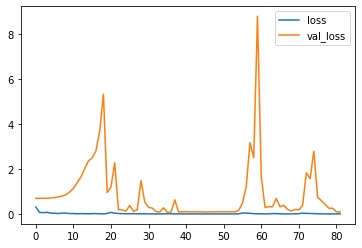

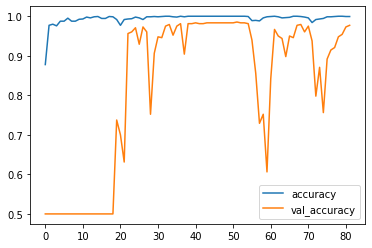

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
15/15 [==============================] - 1s 29ms/step - loss: 0.0995 - accuracy: 0.9854
test loss, test acc: [0.09945137798786163, 0.9854166507720947]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

15/15 [==============================] - 1s 26ms/step


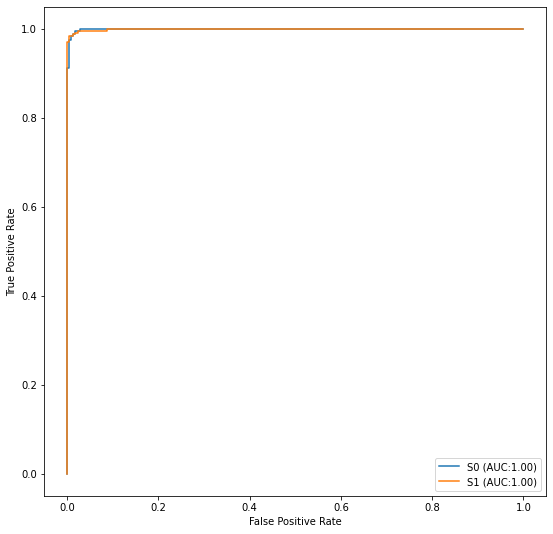

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

83697664/83683744 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 11s 291ms/step - loss: 0.2130 - accuracy: 0.9264 - val_loss: 0.7987 - val_accuracy: 0.9792
Epoch 2/100
23/23 [==============================] - 6s 247ms/step - loss: 0.0419 - accuracy: 0.9889 - val_loss: 1.9236 - val_accuracy: 0.8729
Epoch 3/100
23/23 [==============================] - 6s 247ms/step - loss: 0.0255 - accuracy: 0.9896 - val_loss: 2.6780 - val_accuracy: 0.8292
Epoch 4/100
23/23 [==============================] - 6s 252ms/step - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.2642 - val_accuracy: 0.9833
Epoch 5/100
23/23 [==============================] - 6s 247ms/step - loss: 0.0078 - accuracy: 0.9986 - val_loss: 2.3090 - val_accuracy: 0.8896
Epoch 6/100
23/23 [==============================] - 6s 246ms/step - loss: 0.0261 - accuracy: 0.9931 - val_loss: 2.5595 - val_accuracy: 0.8062
Epoch 7/100
23/23 [==============================] - 6s 247ms/step - loss: 0.0144 - accuracy: 0.9951 - val_loss: 0.3932 - val_accuracy: 0.952

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.212983,0.926389,0.798709,0.979167
1,0.041898,0.988889,1.923647,0.872917
2,0.025457,0.989583,2.677961,0.829167
3,0.007605,0.997917,0.264198,0.983333
4,0.007808,0.998611,2.308952,0.889583
5,0.026116,0.993056,2.559474,0.806250
6,0.014408,0.995139,0.393166,0.952083
7,0.008735,0.997917,0.042651,0.987500
8,0.032133,0.993750,0.392363,0.956250
9,0.020597,0.995139,0.270900,0.943750


Minimum validation loss: 0.0052826376631855965
Maximum validation accuracy: 0.9979166388511658


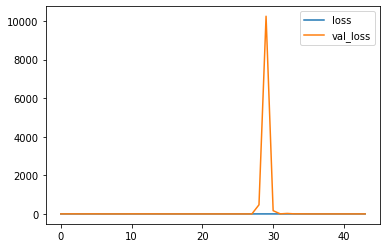

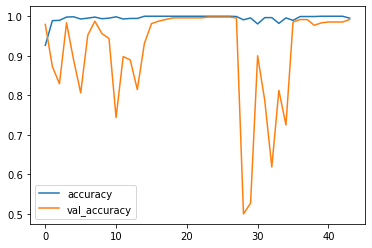

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
15/15 [==============================] - 1s 30ms/step - loss: 8.3466e-04 - accuracy: 1.0000
test loss, test acc: [0.0008346643298864365, 1.0]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

15/15 [==============================] - 1s 27ms/step


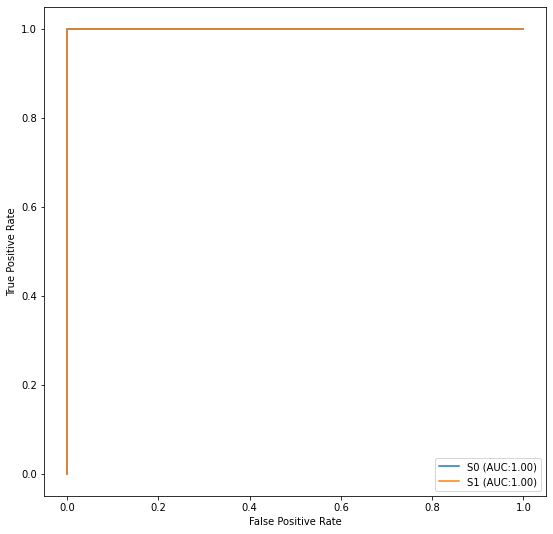

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 12s 283ms/step - loss: 0.4693 - accuracy: 0.7937 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 7s 250ms/step - loss: 0.2655 - accuracy: 0.9042 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/100
30/30 [==============================] - 7s 250ms/step - loss: 0.2193 - accuracy: 0.9198 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/100
30/30 [==============================] - 7s 250ms/step - loss: 0.1434 - accuracy: 0.9411 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/100
30/30 [==============================] - 7s 251ms/step - loss: 0.0971 - accuracy: 0.9630 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/100
30/30 [==============================] - 7s 250ms/step - loss: 0.0954 - accuracy: 0.9708 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 7/100
30/30 [==============================] - 7s 251ms/step - loss: 0.0879 - accuracy: 0.9693 - val_loss: 0.6914 - val_accuracy: 0.500

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.469285,0.793750,0.693132,0.500000
1,0.265482,0.904167,0.693138,0.500000
2,0.219301,0.919792,0.693197,0.500000
3,0.143434,0.941146,0.692959,0.500000
4,0.097134,0.963021,0.693053,0.500000
...,...,...,...,...
73,0.006981,0.998438,0.327938,0.929688
74,0.000712,0.999479,0.407358,0.925000
75,0.002400,0.999479,0.501987,0.917188
76,0.020867,0.993750,3.114347,0.707812


Minimum validation loss: 0.1342507153749466
Maximum validation accuracy: 0.9703124761581421


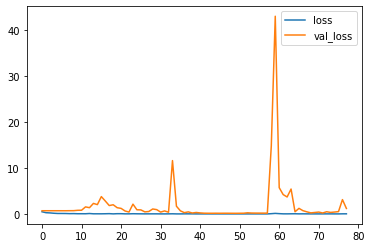

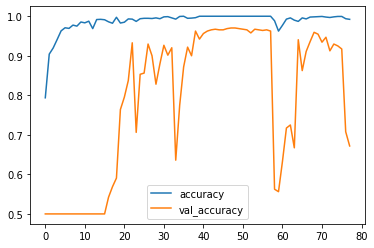

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
20/20 [==============================] - 1s 29ms/step - loss: 0.2492 - accuracy: 0.9500
test loss, test acc: [0.24920693039894104, 0.949999988079071]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

20/20 [==============================] - 1s 27ms/step


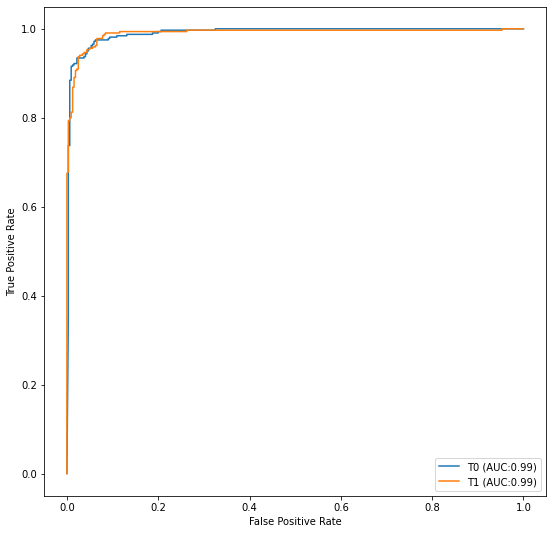

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 12s 284ms/step - loss: 0.2448 - accuracy: 0.8885 - val_loss: 18.8356 - val_accuracy: 0.7141
Epoch 2/100
30/30 [==============================] - 8s 255ms/step - loss: 0.0896 - accuracy: 0.9724 - val_loss: 2.8950 - val_accuracy: 0.7750
Epoch 3/100
30/30 [==============================] - 8s 255ms/step - loss: 0.0917 - accuracy: 0.9682 - val_loss: 0.2512 - val_accuracy: 0.9594
Epoch 4/100
30/30 [==============================] - 8s 251ms/step - loss: 0.0203 - accuracy: 0.9948 - val_loss: 1.0601 - val_accuracy: 0.8734
Epoch 5/100
30/30 [==============================] - 8s 251ms/step - loss: 0.0280 - accuracy: 0.9906 - val_loss: 1.3375 - val_accuracy: 0.8609
Epoch 6/100
30/30 [==============================] - 8s 255ms/step - loss: 0.0133 - accuracy: 0.9958 - val_loss: 0.0280 - val_accuracy: 0.9937
Epoch 7/100
30/30 [==============================] - 8s 254ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0134 - val_accuracy: 0.99

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.244826,0.888542,18.835648,0.714063
1,0.089552,0.972396,2.894964,0.775000
2,0.091678,0.968229,0.251184,0.959375
3,0.020345,0.994792,1.060100,0.873438
4,0.028008,0.990625,1.337475,0.860937
5,0.013295,0.995833,0.028029,0.993750
6,0.002234,0.999479,0.013369,0.998438
7,0.003666,0.998958,0.050199,0.990625
8,0.021575,0.994792,0.157024,0.978125
9,0.012115,0.996875,0.390888,0.940625


Minimum validation loss: 0.013368779793381691
Maximum validation accuracy: 0.9984375238418579


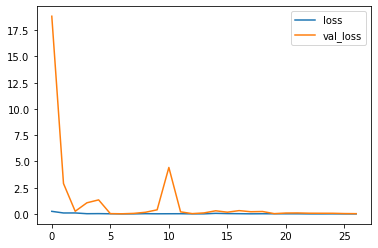

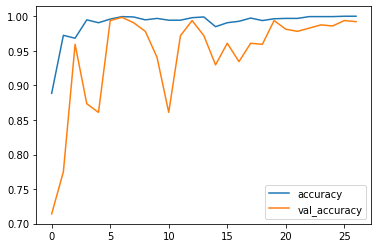

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
20/20 [==============================] - 1s 29ms/step - loss: 0.0459 - accuracy: 0.9922
test loss, test acc: [0.04585724323987961, 0.9921875]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

20/20 [==============================] - 1s 27ms/step


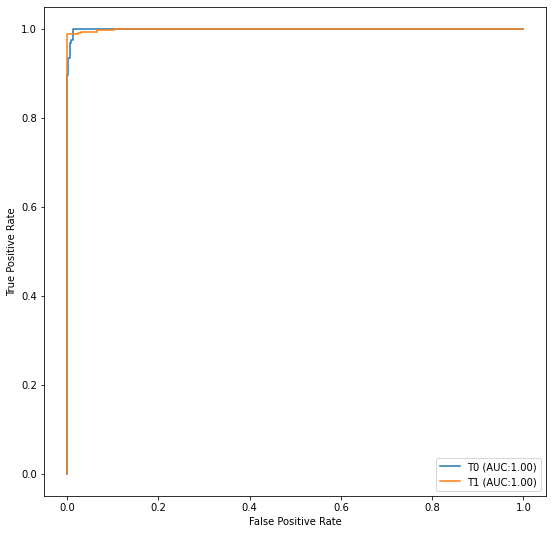

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_Xception_None
test loss, test acc: [0.09945137798786163, 0.9854166507720947]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_Xception_imagenet
test loss, test acc: [0.0008346643298864365, 1.0]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_Xception_None
test loss, test acc: [0.24920693039894104, 0.949999988079071]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_Xception_imagenet
test loss, test acc: [0.04585724323987961, 0.9921875]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_Xception_None →→→ Target Test
20/20 [==============================] - 1s 29ms/step - loss: 3.3157 - accuracy: 0.6438
test loss, test acc: [3.3156585693359375, 0.643750011920929]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_Xception_imagenet →→→ Target Test
20/20 [==============================] - 1s 29ms/step - loss: 3.2079 - accuracy: 0.6906
test loss, test acc: [3.2078723907470703, 0.690625011920929]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_Xception_None →→→ Source Test
15/15 [==============================] - 0s 29ms/step - loss: 3.0069 - accuracy: 0.5875
test loss, test acc: [3.0068914890289307, 0.5874999761581421]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_Xception_imagenet →→→ Source Test
15/15 [==============================] - 0s 29ms/step - loss: 3.7527 - accuracy: 0.6833
test loss, test acc: [3.7527012825012207, 0.6833333373069763]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
